# Phylo2Vec demo

Welcome to the Phylo2Vec demo! Here, we will quickly visit the main functions of Phylo2Vec, including:
* How to sample random tree topologies (cladograms) as Phylo2Vec vectors
* How to convert Phylo2Vec vectors to Newick format and vice versa
* How to sample random trees with branch lengths (phylograms) as Phylo2Vec matrices
* How to convert these matrices to Newick format and vice versa
* Tree traversal utilities: common ancestors and node depths
* Tree comparison metrics: Robinson-Foulds distance
* Other useful operations on Phylo2Vec vectors

Note that the current version of Phylo2Vec (1.x) relies on a core written in Rust, with bindings to Python and R. This comes with significant speed-ups, allowing manipulation large trees (up to ~100,000 to 1 million leaves). To become more familiar with Rust, we recommend this [interactive book](https://rust-book.cs.brown.edu/experiment-intro.html).

## 1. Imports

### 1.1. Rust core

* Currently, most functions of Phylo2Vec are written in Rust. There are many reasons to like Rust that make it desirable for this project, especially its speed, type and memory safety, and portability to other high-level languages like Python and R.  
* Most functions written in Rust are available in Python (and soon in R) via [PyO3](https://pyo3.rs/v0.24.2/) which provides Rust bindings for Python (via a module called here ```_phylo2vec_core```). Thus, most Python functions consist in thin wrappers of the Rust functions.

### 1.2. Other dependencies

* The Python side of Phylo2Vec requires [NumPy](https://numpy.org/) for array manipulations. Here, we will also use [ete](https://github.com/etetoolkit/ete), a useful Python toolkit for tree manipulation and visualisation.

In [ ]:
import os

import numpy as np

from ete4 import Tree

# To run the notebook here, we need to change the working directory
# to py-phylo2vec, which is the parent directory of the Python package.
os.chdir("../py-phylo2vec")

import phylo2vec as p2v
import phylo2vec._phylo2vec_core as core

## 2. Core functions

### 2.1. Sampling a random tree

Use ```sample_vector``` to sample a random tree topology. This function takes two arguments:
* ```n_leaves```, the desired number of leaves/tips in the tree
* ```ordered```, a boolean to sample _ordered_ or _unordered_ trees. This notion was introduced in our [published article](https://doi.org/10.1093/sysbio/syae030) ([preprint](https://arxiv.org/abs/2304.12693)) - a brief summary is described below:

| Characteristic             | **Ordered**                   | **Unordered**                  |
|----------------------------|-------------------------------|--------------------------------|
| Constraint                 | ```v[i]``` $\in \{0, 1, \ldots, i\}$ | ```v[i]``` $\in \{0, 1, \ldots, 2i\}$ |
| Description                | Similar to birth processes    | Bijection of binary tree space |
| Meaning of ```v[i]```      | leaf that forms a cherry with leaf $i$ at iteration $i$  | branch that splits and yields leaf $i$ at iteration $i$ |


In [ ]:
v = p2v.sample_vector(n_leaves=7)

print(repr(v))

array([0, 0, 1, 5, 8, 5])


In [ ]:
v_ordered = p2v.sample_vector(n_leaves=7, ordered=True)

print(repr(v_ordered))

array([0, 0, 0, 2, 2, 2])


To check that a vector is valid according to the Phylo2Vec formulation, use ```check_vector```.

In [ ]:
import warnings
from phylo2vec.utils.vector import check_vector

check_vector(v) # returns None

v_awkward = v.copy()

v_awkward[5] = 11

try:
    check_vector(v_awkward) # PanicException
except AssertionError as err:
    warnings.warn(f"Oops!: {err}")

check_vector raised a PanicException! Validation failed: v[5] = 11 is out of bounds (max = 10)


thread '<unnamed>' panicked at phylo2vec/src/vector/base.rs:60:5:
Validation failed: v[5] = 11 is out of bounds (max = 10)


### 2.2. Conversion to other formats

* Part of the library's goal is to offer functions to convert a phylogenetic tree encoded as a Phylo2Vec vectors in to various formats, including Newick strings, edge lists, and other intermediate formats derived from Phylo2Vec/Newick conversion functions.

#### 2.2.1. Newick string

##### Converting a vector to a Newick string

Use ```to_newick``` to convert a vector to a Newick string.

In [ ]:
newick = p2v.to_newick(v)

newick

'((((0,2)9,4)10,(1,3)8)11,(5,6)7)12;'

Under the hood, ```to_newick``` performs two operations. ```get_pairs``` and ```_build_newick```.

```get_pairs``` produces an ordered list of pairs of leaves from the vector (as a post-order traversal), making use of [AVL trees](https://en.wikipedia.org/wiki/AVL_tree). Each element corresponds to a cherry with its parental node: [children1, children2, parent].

In this example, we have that:
* leaves (1, 6) form a first cherry → 1 = min(1, 6) so leaf 1 is the representative of that cherry
* leaves (4, 5) form a second cherry → 4 = min(4, 5) so leaf 4 is the representative of that cherry
* leaves (2, 3) form a third cherry → 2 = min(2, 3) so leaf 2 is the representative of that cherry
* (0, 1): 1 was already visited in the first cherry, so leaf 0 forms a cherry with the parent of leaf 1
* (0, 4): both were already visited, so the parents of leaf 0 and leaf 4 form a cherry
* (0, 2): both were already visited, to the parents of leaf 0 and leaf 2 form a cherry

In [ ]:
v_fixed = np.array([0, 2, 2, 5, 4, 1])

pairs = core.get_pairs(v_fixed)

pairs

[(1, 6), (4, 5), (2, 3), (0, 1), (0, 4), (0, 2)]

```build_newick``` takes the list of pairs and forms a Newick string (with internal labels (or "parents"))

In [ ]:
newick_fixed = core.build_newick(pairs)

newick_fixed2 = p2v.to_newick(v_fixed)

assert newick_fixed == newick_fixed2  # should be the same

newick_fixed2

'(((0,(1,6)7)10,(4,5)8)11,(2,3)9)12;'

For visualisation purposes, we can plot the tree using ete

We observe the same "cherries" as described above: 
* (1, 6), which merges with 0
* (4, 5), which then merges with the subtree (0,(1,6))
* (2, 3), which then merges with the subtree ((0,(1,6)),(4,5))

In [ ]:
def plot_tree(newick):
    print(Tree(newick))

plot_tree(newick_fixed)

   ╭─┬╴0
 ╭─┤ ╰─┬╴1
 │ │   ╰╴6
─┤ ╰─┬╴4
 │   ╰╴5
 ╰─┬╴2
   ╰╴3


##### Converting a Newick to a vector

Use ```from_newick``` to convert a Newick string to a vector.

In [ ]:
# Let's generate a new v with 7 leaves using sample
v7 = p2v.sample_vector(7)
print(f"v (sampled): {repr(v7)}")

newick7 = p2v.to_newick(v7)
print(f"newick: {newick7}")

v7_new = p2v.from_newick(newick7)
print(f"v (convert): {repr(v7_new)}")

assert np.array_equal(v7, v7_new)  # should be the same

v (sampled): array([0, 2, 3, 4, 1, 8])
newick: (((((0,(1,5)7)8,4)9,6)10,3)11,2)12;
v (convert): array([0, 2, 3, 4, 1, 8])


We can also convert Newick strings without parent labels. Several functions are provided in ```phylo2vec.utils.newick``` to process Newick strings.

In [ ]:
from phylo2vec.utils.newick import remove_parent_labels

newick7_no_parent = remove_parent_labels(newick7)

print(f"Newick with parent labels: {newick7}")
print(f"Newick without parent labels: {newick7_no_parent}")

v7_no_parent = p2v.from_newick(newick7_no_parent)
print(f"v (converted without parents): {repr(v7_new)}")

assert np.array_equal(v7, v7_no_parent)  # should be the same

Newick with parent labels: (((((0,(1,5)7)8,4)9,6)10,3)11,2)12;
Newick without parent labels: (((((0,(1,5)),4),6),3),2);
v (converted without parents): array([0, 2, 3, 4, 1, 8])


#### 2.2.2. Edge list

For a tree with $n$ leaves, we can derive a list of edges of length $2 (n-1)$

Use ```to_edges``` to convert a vector to a list of tree edges (node1, node2)

In [ ]:
edges = p2v.to_edges(v_fixed)

print(edges)

[(1, 7), (6, 7), (4, 8), (5, 8), (2, 9), (3, 9), (0, 10), (7, 10), (10, 11), (8, 11), (11, 12), (9, 12)]


Use ```from_edges``` to convert a list of edges back to a vector

In [ ]:
v_fixed_from_edges = p2v.from_edges(edges)

assert np.array_equal(v_fixed, v_fixed_from_edges)  # should be the same

#### 2.2.3. Ancestry

A visually useful format that was derived in previous versions of Phylo2Vec is the so-called "ancestry" matrix.

For a tree with $n$ leaves, the ancestry matrix is of size $(n-1, 3)$ describing a list of triplets (node1, node2, parent)

Use ```to_ancestry``` to convert a vector to an ancestry matrix

In [ ]:
ancestry = p2v.to_ancestry(v_fixed)

print(repr(ancestry))

array([[ 1,  6,  7],
       [ 4,  5,  8],
       [ 2,  3,  9],
       [ 0,  7, 10],
       [10,  8, 11],
       [11,  9, 12]])


Use ```from_ancestry``` to convert an ancestry matrix back to a vector

In [ ]:
v_fixed_from_ancestry = p2v.from_ancestry(ancestry)

assert np.array_equal(v_fixed, v_fixed_from_ancestry)  # should be the same

#### 2.2.4. "Pairs"

Another intermediate format from the Phylo2Vec/Newick conversion functions is a so-called list of pairs.

For a tree with $n$ leaves, the pair list is of length $n-1$.

Each pair corresponds to a list of tuples, where each pair is represented as a tuple (B, L) indicating that leaf L descends from branch B.

Use ```to_pairs``` to convert a vector to a list of pairs

In [ ]:
pairs = p2v.to_pairs(v_fixed)

print(pairs)

[(1, 6), (4, 5), (2, 3), (0, 1), (0, 4), (0, 2)]


Use ```from_pairs``` to convert a list of pairs back to a vector

In [ ]:
v_fixed_from_pairs = p2v.from_pairs(pairs)

assert np.array_equal(v_fixed, v_fixed_from_pairs)  # should be the same

### 2.4 Matrix format

* Newick strings can also have branch lengths, so it is also desirable to store not only the topology (which the core Phylo2Vec does), but also the branch lengths

In this setup:
 * The 1st column is v[i] (i.e., the Phylo2Vec vector)
 * The 2nd and 3rd columns are the ordered branch lengths of cherry in the ancestry matrix. The order of the branch lengths is determined by the _smallest descendant_ of the ancestry nodes. The node with the smallest descendant will have the branch length in the 2nd column, and the other the branch length in the 3rd column.

The plot below shows: how to recover a tree from the phylo2vec vector $\boldsymbol{v} = [0, 2, 0, 4]$. (a) Main algorithm for leaf placement. (b) Augmenting the phylo2vec vector into a matrix $\boldsymbol{m}$ with branch lengths. We use an intermediary ancestry matrix whereby each row describes a cherry (two children nodes and the parent node), which we augment with two columns of branch lengths. The node with the smallest descendant will have the branch length in the 2nd column, and the other the branch length in the 3rd column.

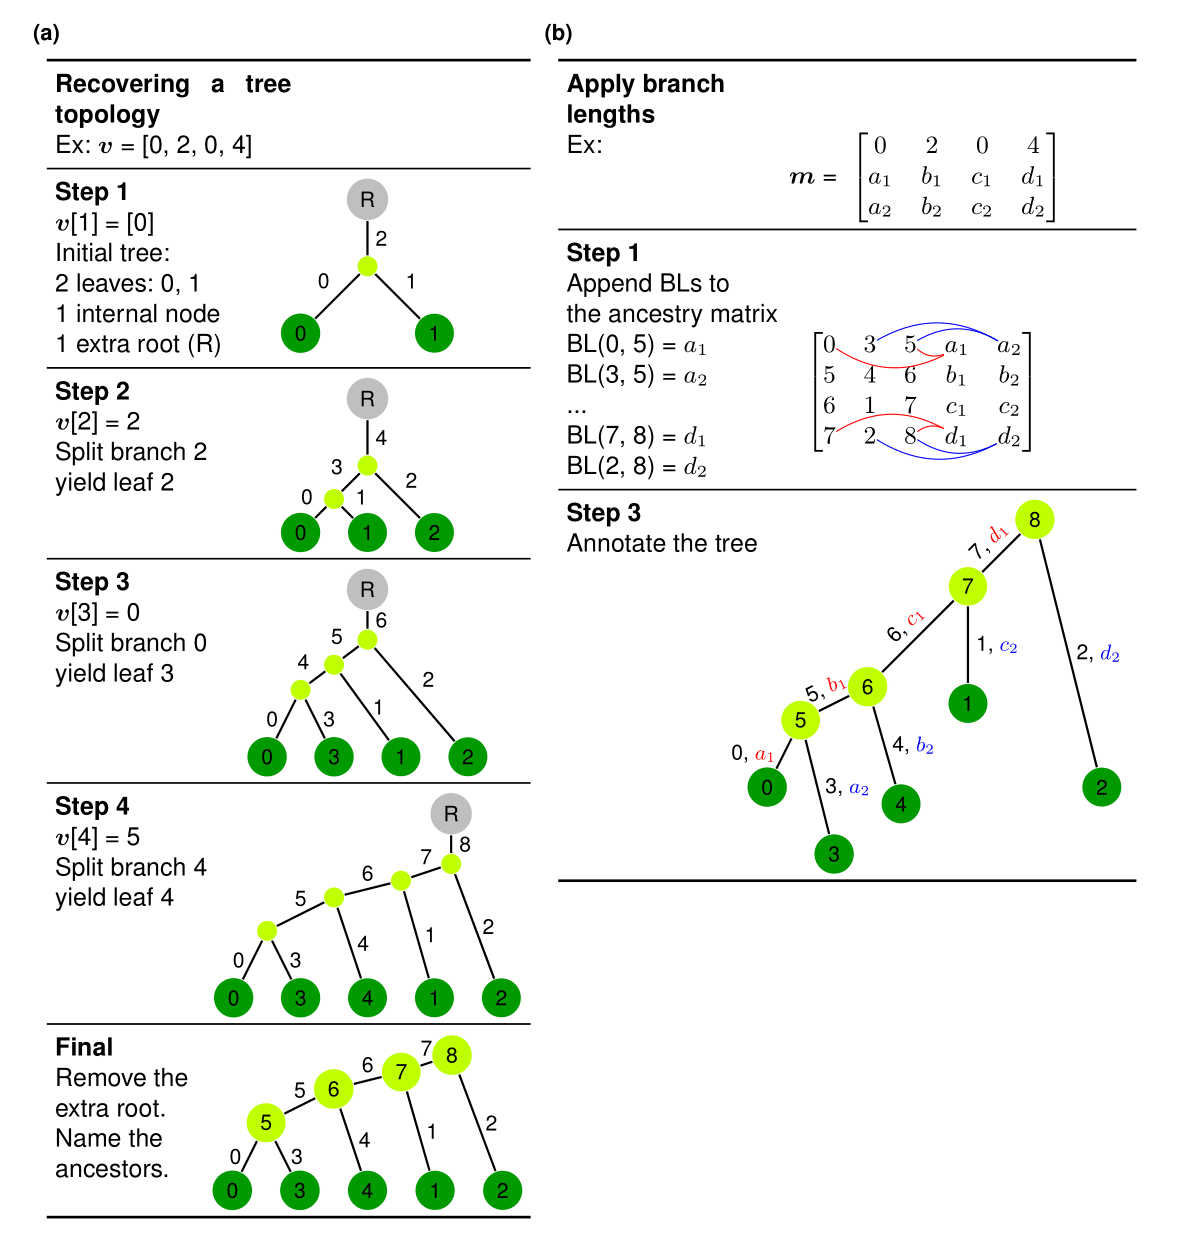

In [ ]:
from IPython.display import Image

Image("../docs/img/fig2.png", width=600)

Under the hood, ```from_newick``` checks whether the Newick string has branch lengths or not, and ```to_newick``` checks whether the input is a vector or a matrix, and performs the conversion. So we can use the same functions as before!

In [ ]:
from phylo2vec import sample_matrix

n_leaves = 5

m5 = sample_matrix(n_leaves)

print(f"m (sampled):\n{repr(m5)}")

m (sampled):
array([[0.        , 0.05586577, 0.73334581],
       [0.        , 0.38201654, 0.61142737],
       [4.        , 0.85919964, 0.30591026],
       [0.        , 0.25750902, 0.02408398]])


In [ ]:
newick_with_bls = p2v.to_newick(m5)

print(newick_with_bls)

((((0:0.055865772,4:0.7333458)5:0.38201654,2:0.61142737)6:0.85919964,1:0.30591026)7:0.25750902,3:0.02408398)8;


In [ ]:
m5_other = p2v.from_newick(newick_with_bls)

assert np.array_equal(m5, m5_other)  # should be the same

## 3. Other utility functions

### 3.1. Stats

We believe it is possible to implement a wide variety of statistics pertaining to trees using the Phylo2Vec format.

These can be distances between trees (we evoked calculating a Hamming distance between vectors in the Phylo2Vec paper), but also between nodes/leaves within a tree. 

An example of the latter is the [cophenetic distance](https://en.wikipedia.org/wiki/Cophenetic).

In [ ]:
from phylo2vec.stats import pairwise_distances

print(f"vector:\n{repr(v_fixed)}")

print(f"Cophenetic distance matrix (topology):\n{pairwise_distances(v_fixed, metric='cophenetic')}")

vector:
array([0, 2, 2, 5, 4, 1])
Cophenetic distance matrix (topology):
[[0 3 5 5 4 4 3]
 [3 0 6 6 5 5 2]
 [5 6 0 2 5 5 6]
 [5 6 2 0 5 5 6]
 [4 5 5 5 0 2 5]
 [4 5 5 5 2 0 5]
 [3 2 6 6 5 5 0]]


In [ ]:
m5 = np.array(
    [
        [0.0, 0.05586577, 0.73334581],
        [0.0, 0.38201654, 0.61142737],
        [4.0, 0.85919964, 0.30591026],
        [0.0, 0.25750902, 0.02408398],
    ]
)

print(f"matrix:\n{repr(m5)}")

print(
    f"Cophenetic distance matrix (rounded):\n{pairwise_distances(m5, metric='cophenetic').round(3)}"
)

matrix:
array([[0.        , 0.05586577, 0.73334581],
       [0.        , 0.38201654, 0.61142737],
       [4.        , 0.85919964, 0.30591026],
       [0.        , 0.25750902, 0.02408398]])
Cophenetic distance matrix (rounded):
[[0.    1.603 1.049 1.579 0.789]
 [1.603 0.    1.777 0.588 2.28 ]
 [1.049 1.777 0.    1.752 1.727]
 [1.579 0.588 1.752 0.    2.256]
 [0.789 2.28  1.727 2.256 0.   ]]


Another important tree distance metric is the [Robinson-Foulds (RF) distance](https://en.wikipedia.org/wiki/Robinson%E2%80%93Foulds_metric), which counts the number of bipartitions (splits) that differ between two tree topologies.

Use `robinson_foulds` to compute the RF distance between two trees.

In [ ]:
from phylo2vec.stats import robinson_foulds

# Sample two random trees with 10 leaves
v1 = p2v.sample_vector(10)
v2 = p2v.sample_vector(10)

print(f"Tree 1: {repr(v1)}")
print(f"Tree 2: {repr(v2)}")

# Compute RF distance
rf_dist = robinson_foulds(v1, v2)
print(f"Robinson-Foulds distance: {rf_dist}")

# Normalized RF distance (range [0, 1])
rf_norm = robinson_foulds(v1, v2, normalize=True)
print(f"Normalized RF distance: {rf_norm:.3f}")

# RF distance of a tree with itself is always 0
rf_same = robinson_foulds(v1, v1)
print(f"RF distance (same tree): {rf_same}")

### 3.2. Tree traversal: common ancestors and node depths

Phylo2Vec provides functions for tree traversal, such as finding the most recent common ancestor (MRCA) between two nodes and computing node depths.

Use `get_common_ancestor` to find the MRCA between two nodes (similar to ape's `getMRCA` in R or ETE's `get_common_ancestor` in Python), and `get_node_depth` / `get_node_depths` to compute depths.

- For **vectors**: topological depth is returned (all branch lengths = 1)
- For **matrices**: actual branch lengths are used

**Tip:** Use `get_node_depths` (plural) to compute all node depths at once, which is more efficient than calling `get_node_depth` repeatedly.

In [ ]:
from phylo2vec.utils.vector import get_common_ancestor, get_node_depth, get_node_depths

# Using v_fixed from earlier: [0, 2, 2, 5, 4, 1]
# Tree structure (7 leaves, so internal nodes are 7-12, root is 12):
#    ╭─┬╴0
#  ╭─┤ ╰─┬╴1
#  │ │   ╰╴6
# ─┤ ╰─┬╴4
#  │   ╰╴5
#  ╰─┬╴2
#    ╰╴3

# Find MRCA of leaves 1 and 6 (they form a cherry, so MRCA is node 7)
mrca_1_6 = get_common_ancestor(v_fixed, 1, 6)
print(f"MRCA of leaves 1 and 6: node {mrca_1_6}")
assert mrca_1_6 == 7  # node 7 is the parent of leaves 1 and 6

# Get the depth of this MRCA (topological, since v_fixed is a vector)
mrca_depth = get_node_depth(v_fixed, mrca_1_6)
print(f"Depth of MRCA (node {mrca_1_6}): {mrca_depth}")
assert mrca_depth == 3  # root(12) → 11 → 10 → 7, so depth is 3

# Find MRCA of leaves 2 and 5 (MRCA is root, node 12)
mrca_2_5 = get_common_ancestor(v_fixed, 2, 5)
mrca_2_5_depth = get_node_depth(v_fixed, mrca_2_5)
print(f"MRCA of leaves 2 and 5: node {mrca_2_5}, depth: {mrca_2_5_depth}")
assert mrca_2_5 == 12  # root node
assert mrca_2_5_depth == 0  # root has depth 0

# Get all node depths at once
all_depths = get_node_depths(v_fixed)
print(f"All node depths: {all_depths}")
assert all_depths[12] == 0  # root depth is 0

### 3.3 Optimisation

In the Phylo2Vec paper, we showcased a hill-climbing optimisation scheme to demonstrate the potential of phylo2vec for maximum likelihood-based phylogenetic inference. We also contributed to [GradME](https://github.com/Neclow/GradME), a continuous extension of phylo2vec for gradient-based minimum evolution.

These optimisation schemes (written in `phylo2vec.opt`) are demonstrated in the [demo_opt notebook](demo_opt.ipynb).

### 3.4 Other utility functions

#### 3.4.1 Finding the number of leaves in a Newick

In [ ]:
from phylo2vec.utils.newick import find_num_leaves

assert find_num_leaves(newick7) == 7

#### 3.4.2 Removing and adding a leaf in a tree

One might want to prune or add nodes in an existing tree (a common example is the subtree-prune-and-regraft operation).

This is not a trivial operation as we need to re-compute the vector (as the number of leaves in the tree will have changed)

In [ ]:
from phylo2vec.utils.vector import remove_leaf

leaf = 3

# sister_leaf = Sister node of `leaf``in `v7`
v6, sister_leaf = remove_leaf(v7, leaf=leaf)

In [ ]:
plot_tree(newick7)
plot_tree(p2v.to_newick(v6))


               /-0
            /-|
           |  |   /-1
         /-|   \-|
        |  |      \-5
      /-|  |
     |  |   \-4
   /-|  |
  |  |   \-6
--|  |
  |   \-3
  |
   \-2

            /-0
         /-|
        |  |   /-1
      /-|   \-|
     |  |      \-4
   /-|  |
  |  |   \-3
--|  |
  |   \-5
  |
   \-2


In [ ]:
from phylo2vec.utils.vector import add_leaf

# due to re-labelling in remove_leaf, we have to decrement sister_leaf
if sister_leaf >= leaf:
    sister_leaf -= 1

v_add = add_leaf(v6, leaf=3, pos=sister_leaf)

np.array_equal(v_add, v7)

True

#### 3.4.3 Applying and create an integer mapping from a Newick string

* Newick strings usually do not contain integers but real-life taxa (e.g., animal species, languages...). So it is important to provide another layer of conversion, where we can take in a Newick with string taxa, and convert it to a Newick with integer taxa, with a unique integer → taxon mapping.

In [ ]:
n_leaves = 8

t = Tree()
t.populate(n_leaves)
nw_str = t.write(parser=9)

print(nw_str)

print(t)

((((e,g),f),((c,h),a)),(b,d));
     ╭─┬╴e
   ╭─┤ ╰╴g
 ╭─┤ ╰╴f
 │ │ ╭─┬╴c
─┤ ╰─┤ ╰╴h
 │   ╰╴a
 ╰─┬╴b
   ╰╴d


In [ ]:
from pprint import pprint
from phylo2vec.utils.newick import create_label_mapping

nw_int, label_mapping = create_label_mapping(nw_str)

plot_tree(nw_int)

pprint(label_mapping)

     ╭─┬╴0
   ╭─┤ ╰╴1
 ╭─┤ ╰╴2
 │ │ ╭─┬╴3
─┤ ╰─┤ ╰╴4
 │   ╰╴5
 ╰─┬╴6
   ╰╴7
{0: 'e', 1: 'g', 2: 'f', 3: 'c', 4: 'h', 5: 'a', 6: 'b', 7: 'd'}


* The reverse operation is ```apply_label_mapping```

In [ ]:
from phylo2vec.utils.newick import apply_label_mapping

new_nw_str = apply_label_mapping(nw_int, label_mapping)

new_nw_str == nw_str

True

## 4. I/O: saving and writing files

It is also possible to save/write and load/read some files. Phylo2Vec supports various file formats for both arrays and Newick strings, making it versatile for different use cases.

### 4.1. Supported File Extensions

Phylo2Vec accepts the following file extensions for arrays and Newick strings:

- **Array file extensions** (for Phylo2Vec vector/matrices): `.csv`, `.txt`
- **Newick file extensions**: `.txt`, `.nwk`, `.newick`, `.tree`, `.treefile`

These extensions ensure compatibility with other programming languages as well as commonly used formats in phylogenetics and computational biology.

In [ ]:
import tempfile

from glob import glob

from phylo2vec.io._validation import FILE_EXTENSIONS


print(f"Accepted array file extensions: {FILE_EXTENSIONS['array']}")
print(f"Accepted newick file extensions: {FILE_EXTENSIONS['newick']}")

Accepted array file extensions: ['.csv', '.txt']
Accepted newick file extensions: ['.txt', '.nwk', '.newick', '.tree', '.treefile']


### 4.2. Reading/writing arrays

To read and write Phylo2Vec vectors or matrices, use ```load```, and ```save```, respectively

In [ ]:
from phylo2vec import load, save

with tempfile.TemporaryDirectory() as tmpdirname:
    print(f"Creating temporary directory {tmpdirname}...")
    tmpfname_vector = f"{tmpdirname}/v5.txt"
    v = np.array([0, 2, 1, 5])
    print(f"Saving vector: {repr(v)}")
    save(v, tmpfname_vector)

    print(f"Files in {tmpdirname}: {glob(tmpdirname + '/*')}")

    v2 = load(tmpfname_vector)
    print(f"Loaded vector: {repr(v2)}")
    assert np.array_equal(v, v2)  # should be the same

    print()
    tmpfname_matrix = f"{tmpdirname}/m5.txt"

    m = np.array(
        [
            [0.0, 0.83603758, 0.91154987],
            [0.0, 0.99484628, 0.39551872],
            [2.0, 0.24386153, 0.29477531],
            [2.0, 0.13840142, 0.50210303],
        ]
    )
    print(f"Saving matrix:\n{repr(m)}")
    save(m, tmpfname_matrix)

    print(f"Files in {tmpdirname}: {glob(tmpdirname + '/*')}")

    m2 = load(tmpfname_matrix)
    print(f"Loaded matrix:\n{repr(m2)}")

    assert np.array_equal(m, m2)  # should be the same

Creating temporary directory /tmp/tmph0cq8qmj...
Saving vector: array([0, 2, 1, 5])
Files in /tmp/tmph0cq8qmj: ['/tmp/tmph0cq8qmj/v5.txt']
Loaded vector: array([0, 2, 1, 5])

Saving matrix:
array([[0.        , 0.83603758, 0.91154987],
       [0.        , 0.99484628, 0.39551872],
       [2.        , 0.24386153, 0.29477531],
       [2.        , 0.13840142, 0.50210303]])
Files in /tmp/tmph0cq8qmj: ['/tmp/tmph0cq8qmj/m5.txt', '/tmp/tmph0cq8qmj/v5.txt']
Loaded matrix:
array([[0.        , 0.83603758, 0.91154987],
       [0.        , 0.99484628, 0.39551872],
       [2.        , 0.24386153, 0.29477531],
       [2.        , 0.13840142, 0.50210303]])


### 4.3. Reading/writing files containing Newick strings

To load and save Newick strings as Phylo2Vec vectors or matrices, use ```load_newick```, and ```save_newick```, respectively

In [ ]:
from phylo2vec import load_newick, save_newick

with tempfile.TemporaryDirectory() as tmpdirname:
    print(f"Creating temporary directory {tmpdirname}...")
    tmpfname_vector = f"{tmpdirname}/v6.txt"
    v6 = np.array([0, 1, 4, 4, 8])

    print(f"Saving as newick: {repr(v6)}")
    save_newick(v6, tmpfname_vector)

    print(f"Files in {tmpdirname}: {glob(tmpdirname + '/*')}")

    v6_other = load_newick(tmpfname_vector)
    print(f"Loaded newick back to vector: {repr(v6_other)}")
    assert np.array_equal(v6_other, v6)  # should be the same

    print()
    tmpfname_matrix = f"{tmpdirname}/m6.txt"

    m6 = np.array(
        [
            [0.0, 0.68952268, 0.29305875],
            [1.0, 0.94858885, 0.52901864],
            [3.0, 0.98526967, 0.5341301],
            [5.0, 0.39921775, 0.31769511],
        ]
    )
    print(f"Saving as newick:\n{repr(m6)}")
    save_newick(m6, tmpfname_matrix)

    print(f"Files in {tmpdirname}: {glob(tmpdirname + '/*')}")

    m6_other = load_newick(tmpfname_matrix)
    print(f"Loaded newick back to matrix:\n{repr(m6_other)}")

    assert np.allclose(m6, m6_other)  # should be the same

Creating temporary directory /tmp/tmp98wscpp1...
Saving as newick: array([0, 1, 4, 4, 8])
Files in /tmp/tmp98wscpp1: ['/tmp/tmp98wscpp1/v6.txt']
Loaded newick back to vector: array([0, 1, 4, 4, 8])

Saving as newick:
array([[0.        , 0.68952268, 0.29305875],
       [1.        , 0.94858885, 0.52901864],
       [3.        , 0.98526967, 0.5341301 ],
       [5.        , 0.39921775, 0.31769511]])
Files in /tmp/tmp98wscpp1: ['/tmp/tmp98wscpp1/v6.txt', '/tmp/tmp98wscpp1/m6.txt']
Loaded newick back to matrix:
array([[0.        , 0.68952268, 0.29305875],
       [1.        , 0.94858885, 0.52901864],
       [3.        , 0.98526967, 0.5341301 ],
       [5.        , 0.39921775, 0.31769511]])
